[*********************100%***********************]  1 of 1 completed

Fetched 2014 rows of stock data for AAPL
Number of rows in stock data before feature engineering: 2014
Initial stock data:
                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2015-01-02  27.847500  27.860001  26.837500  27.332500  24.373959  212818400
2015-01-05  27.072500  27.162500  26.352501  26.562500  23.687302  257142000
2015-01-06  26.635000  26.857500  26.157499  26.565001  23.689535  263188400
2015-01-07  26.799999  27.049999  26.674999  26.937500  24.021721  160423600
2015-01-08  27.307501  28.037500  27.174999  27.972500  24.944685  237458000
RSI values: 
Date
2022-12-02    51.156320
2022-12-05    49.531665
2022-12-06    44.710749
2022-12-07    42.359444
2022-12-08    45.060249
2022-12-09    44.418019
2022-12-12    48.198958
2022-12-13    49.747349
2022-12-14    46.309569
2022-12-15    37.928881
2022-12-16    35.856399
2022-12-19    33.722442
2022-12-20    33.651935
2022-12-


/Users/tapaswinchiruvanurukumar/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0124
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0015
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0011
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0015
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 9.2832e-04
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0012
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0010
Epoch 8/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 9.2646e-04
Epoch 9/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 8.1786e-04
Epoch 10/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0010
Epoch 11/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 9.4523e-04
Epoch 12/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0011
Epoch 13/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 8.7598e-04
Epoch 14/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 8.3625e-04
Epoch 15/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14

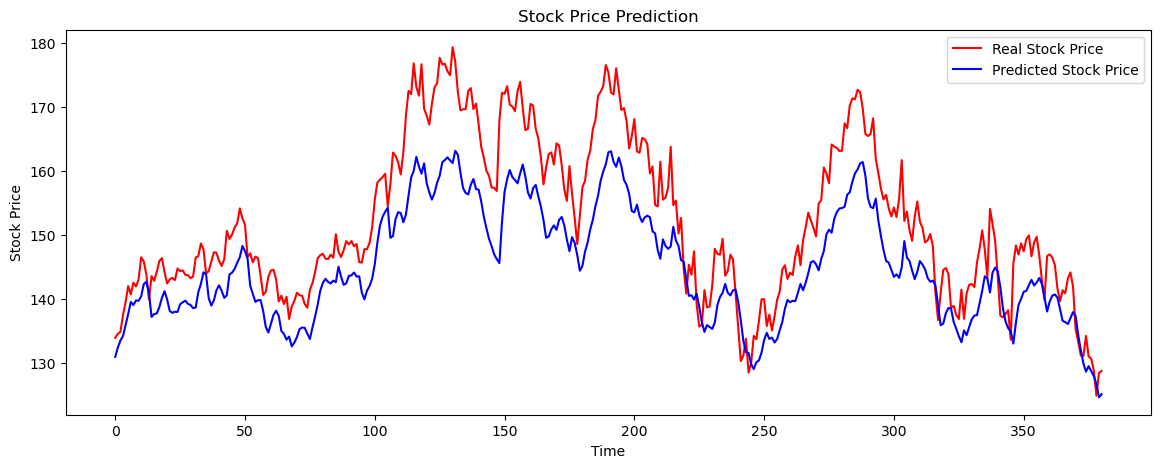

In [1]:
# Import necessary packages
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# Fetch stock data using yfinance
def fetch_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    print(f"Fetched {len(stock_data)} rows of stock data for {ticker}")
    return stock_data

# Feature engineering: Using Adjusted Close prices and technical indicators
def feature_engineering(stock_data):
    print("Initial stock data:")
    print(stock_data.head())  # Print the first few rows of data for debugging
    
    # Reducing the window size to avoid insufficient data problems
    stock_data['MA50'] = stock_data['Adj Close'].rolling(window=20).mean()  # 20-day moving average
    stock_data['MA200'] = stock_data['Adj Close'].rolling(window=50).mean()  # 50-day moving average instead of 200
    
    # Recalculate RSI with a check to ensure proper computation
    stock_data['RSI'] = compute_rsi(stock_data['Adj Close'], 14)
    
    print("Stock data after calculating moving averages and RSI:")
    print(stock_data[['Adj Close', 'MA50', 'MA200', 'RSI']].tail())  # Debugging output

    # Check for NaN values and count them
    nan_count = stock_data.isnull().sum()
    print(f"NaN values after feature engineering:\n{nan_count}")

    # Drop any rows that still have NaN values after calculations
    stock_data = stock_data.dropna()

    # Check if the data is empty after dropping NaNs
    if stock_data.empty:
        raise ValueError("After feature engineering, the data contains no valid rows. Please check the stock data.")

    return stock_data

# Compute RSI (Relative Strength Index) using Wilder's smoothing
def compute_rsi(series, period):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    # Use exponential weighted moving average
    avg_gain = gain.ewm(alpha=1/period, min_periods=period).mean()
    avg_loss = loss.ewm(alpha=1/period, min_periods=period).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    # Handle division by zero if avg_loss is zero
    rsi = rsi.replace([np.inf, -np.inf], np.nan)
    rsi = rsi.fillna(0)

    # Debug RSI output
    print(f"RSI values: \n{rsi.tail(20)}")  # Print the last 20 values of RSI to inspect

    return rsi

# Prepare data for LSTM
def prepare_data(stock_data, feature_cols, target_col):
    scaler = MinMaxScaler(feature_range=(0, 1))

    # Check if there are any NaN values in the feature columns before scaling
    if stock_data[feature_cols].isnull().values.any():
        raise ValueError("NaN values detected in the feature columns. Check the input data.")

    scaled_data = scaler.fit_transform(stock_data[feature_cols].values)

    X = []
    y = []
    for i in range(60, len(stock_data)):
        X.append(scaled_data[i - 60:i, :])
        y.append(scaled_data[i, target_col])

    X, y = np.array(X), np.array(y)

    # If X or y is empty, raise an error
    if X.shape[0] == 0 or y.shape[0] == 0:
        raise ValueError("Not enough data after processing for model input.")

    return X, y, scaler

# Build LSTM model
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Train and evaluate the model
def train_model(model, X_train, y_train, epochs=100, batch_size=32):
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)
    return history

# Predict stock prices
def predict_stock_price(model, X_test, scaler, target_col):
    predicted_stock_price = model.predict(X_test)
    # Only inverse transform the target column
    dummy = np.zeros((predicted_stock_price.shape[0], scaler.n_features_in_))
    dummy[:, target_col] = predicted_stock_price[:, 0]
    predicted_stock_price = scaler.inverse_transform(dummy)[:, target_col]
    return predicted_stock_price

# Plotting function for visualization
def plot_predictions(real_stock_price, predicted_stock_price):
    plt.figure(figsize=(14, 5))
    plt.plot(real_stock_price, color='red', label='Real Stock Price')
    plt.plot(predicted_stock_price, color='blue', label='Predicted Stock Price')
    plt.title('Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

# Example usage
if __name__ == '__main__':
    ticker = 'AAPL'  # Change ticker if needed
    start_date = '2015-01-01'
    end_date = '2023-01-01'

    # Fetching stock data
    stock_data = fetch_stock_data(ticker, start_date, end_date)

    # Debugging: print the number of rows before feature engineering
    print(f"Number of rows in stock data before feature engineering: {len(stock_data)}")

    stock_data = feature_engineering(stock_data)

    # Debugging: print the number of rows after feature engineering
    print(f"Number of rows in stock data after feature engineering: {len(stock_data)}")

    # Prepare data for training and testing
    feature_cols = ['Adj Close', 'MA50', 'MA200', 'RSI']
    target_col = 0  # Index of the target column (Adj Close)
    X, y, scaler = prepare_data(stock_data, feature_cols, target_col)

    # Split the data into training and testing sets
    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    # Build and train the LSTM model
    model = build_lstm_model((X_train.shape[1], X_train.shape[2]))
    history = train_model(model, X_train, y_train, epochs=100)

    # Predict stock prices
    predicted_stock_price = predict_stock_price(model, X_test, scaler, target_col)

    # Plot predictions
    real_stock_price = stock_data['Adj Close'].values[-len(predicted_stock_price):]
    plot_predictions(real_stock_price, predicted_stock_price)


In [3]:
model.save('lstm_stock_model.keras')